**CO3519** - Sentiment Analysis

*Ross Kitcher - rkitcher@uclan.ac.uk*

Application to determine the negative/positive sentiment of the IMDB Movie Reviews dataset using TF-IDF for vectorization and Naive Bayes for classification.

## Import Libraries

Import all libraries used within this project and download any required resources.

In [1]:
from google.colab import drive # To import dataset from google drive.

# Data handling libraries.
import pandas as pd
import numpy as np

import nltk
from nltk import word_tokenize # Word tokenizer.
from nltk.stem import WordNetLemmatizer # Lemmatizer.
import matplotlib.pyplot as plt # Graph plotting.
from string import punctuation # List of punctuation

from sklearn.model_selection import (
    train_test_split, # For splitting train and test data.
    GridSearchCV, # For finding optimal hyperparameters.
    RandomizedSearchCV,
    learning_curve,
    LearningCurveDisplay, # For viewing a classifier's learning curve.
)
from sklearn.feature_extraction.text import TfidfVectorizer # Import vectorizer.
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB # Import classifier.
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

# Import Sklearn's metric functions.
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    make_scorer,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    classification_report,
    roc_curve,
    RocCurveDisplay,
    precision_recall_curve,
    PrecisionRecallDisplay,
    roc_auc_score,
    average_precision_score,
)

nltk.download('punkt') # Download punkt
nltk.download('wordnet') # Download wordnet

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## Dataset Inspection

In this section, the dataset will be imported and inspected to get information such as:


*   Presence of null values.
*   Prescence of incorrect/not descriptive column names.
*   Categories of sentiments.
*   Amount of reviews per sentiment.


First, the dataset is imported.

In [2]:
# Mount Google Drive to access the dataset
drive.mount("/content/gdrive/")

Mounted at /content/gdrive/


In [3]:
reviews_df = pd.read_csv("gdrive/MyDrive/Colab Notebooks/IMDB Dataset.csv") # Read dataset and save to Pandas DataFrame
reviews_df.info() # Output DataFrame structure

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


As shown above, the dataset features two columns with descriptive names, each with 50,000 records.


Now, check for any null values inside either column.

In [4]:
reviews_df.isna().sum() # Output the sum of all null values found.

review       0
sentiment    0
dtype: int64

As no null values have been found, no further action is needed.

Next, identify the categories of sentiments and get the amount of reviews per sentiment category.

In [5]:
reviews_df['sentiment'].value_counts() # Output each unique value inside the column along with the amount of duplicates found.

positive    25000
negative    25000
Name: sentiment, dtype: int64

Two categories have been found - positive and negative - each with an equal amount of rows.

From the checks performed above, no further action is needed on the DataFrame and it is ready to be pre-processed.
### Insights

Using Matplotlib, diagrams can be created to visualise the data present within the Reviews dataset. Histograms will be created to visualise features of the dataset to help generate insights that may influence how the machine learning model is created.

The following aspects will be analysed:

*    Amount of characters used in reviews.
*    Relationship between the length of a review and its sentiment.
*    Amount of unique characters used in review.
*    Relationship between the amount of unique characters in a review and its sentiment.

First, create a histogram to view the character lengths of reviews.

Text(0, 0.5, 'Number of Reviews')

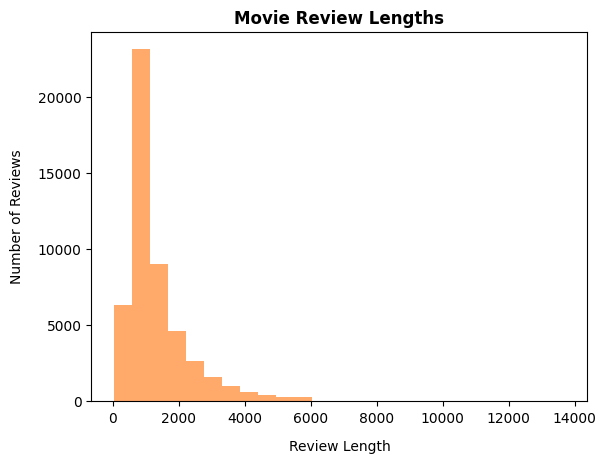

In [6]:
# Create histogram by getting the length of each element in the column Review.
#   Use 25 bins.
#   Disable gridlines.
#   Set colour to orange.
ax = reviews_df['review'].str.len().hist(bins=25, grid=False, color="#ffa96b")


ax.set_title("Movie Review Lengths", weight="bold") # Set title.
ax.set_xlabel("Review Length", labelpad=10) # Set X label.
ax.set_ylabel("Number of Reviews", labelpad=10) # Set Y label.

As shown, the character length of movie reviews range from 0 - 14000, with the most common length being ~1000.

This data can be further separated into positive and negative reviews.

Text(0, 0.5, 'Number of Reviews')

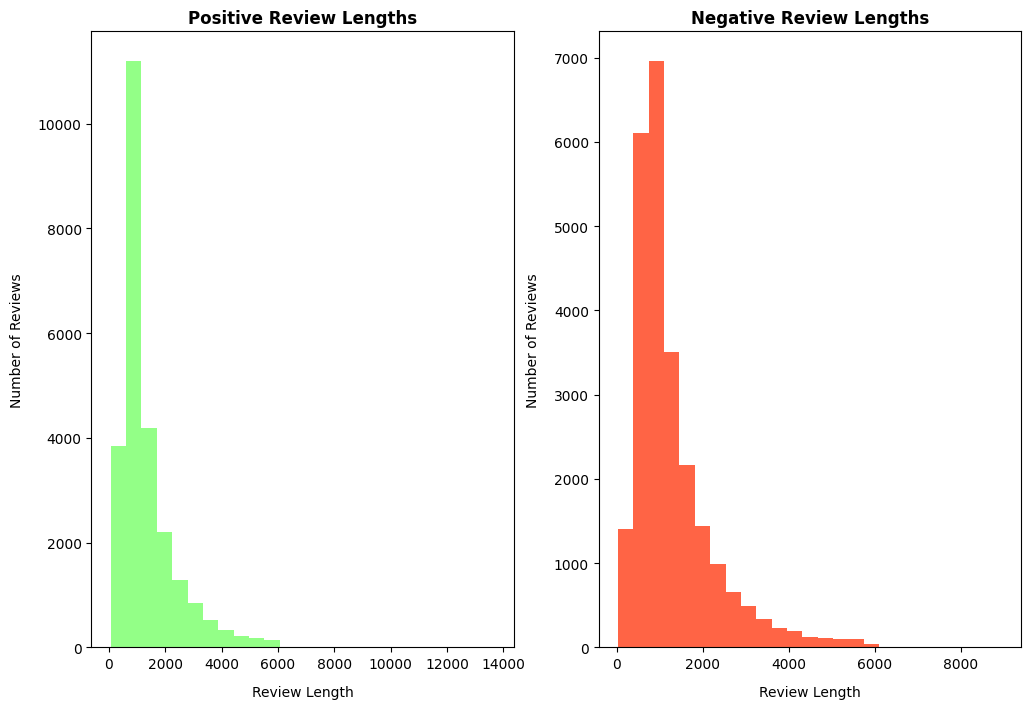

In [7]:
# Create two histograms using the same method as above. Except, only get lengths of reviews for a given sentiment.

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,8))
ax1.hist(reviews_df['review'].where(reviews_df['sentiment'] == "positive").str.len(), bins=25, color="#93ff87")
ax1.set_title("Positive Review Lengths", weight="bold")
ax1.set_xlabel("Review Length", labelpad=10)
ax1.set_ylabel("Number of Reviews", labelpad=10)

ax2.hist(reviews_df['review'].where(reviews_df['sentiment'] == "negative").str.len(), bins=25,  color="#ff6445")
ax2.set_title("Negative Review Lengths", weight="bold")
ax2.set_xlabel("Review Length", labelpad=10)
ax2.set_ylabel("Number of Reviews", labelpad=10)

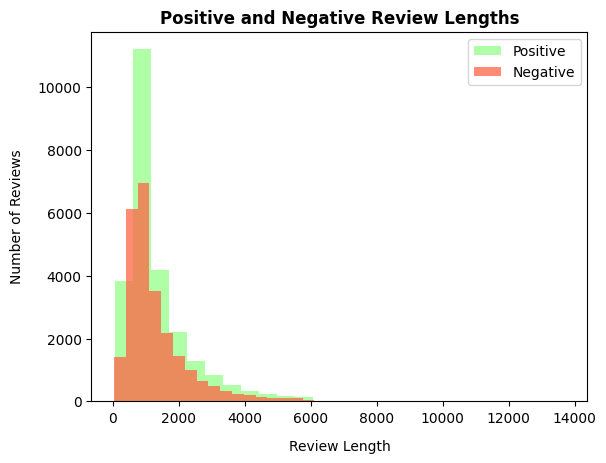

In [8]:
# Create another histogram, this time with both histograms displayed above placed on the same axis.

plt.hist(reviews_df['review'].where(reviews_df['sentiment'] == "positive").str.len(), bins=25, color="#93ff87", label="Positive", alpha=0.75)
plt.hist(reviews_df['review'].where(reviews_df['sentiment'] == "negative").str.len(), bins=25,  color="#ff6445", label="Negative", alpha=0.75)
plt.title("Positive and Negative Review Lengths", weight="bold")
plt.xlabel("Review Length", labelpad=10)
plt.ylabel("Number of Reviews", labelpad=10)
plt.legend()
plt.show()

As shown above, a positive review can have a charcter length of 0 - 14000, whilst a negative review can have a character length of 0 - 9000.

This may indicate that when someone leaves a positive review, they are more inclined to write more text reasoning why. Whereas, a negative review may not feel so inclined to discuss a movie they did not enjoy at length.

When placed on the same histogram, it can be seen that, on average, a positive review is likely to contain more text.

Now, visualise the amount of unique characters used per category of reviewing.

Text(0, 0.5, 'Number of Reviews')

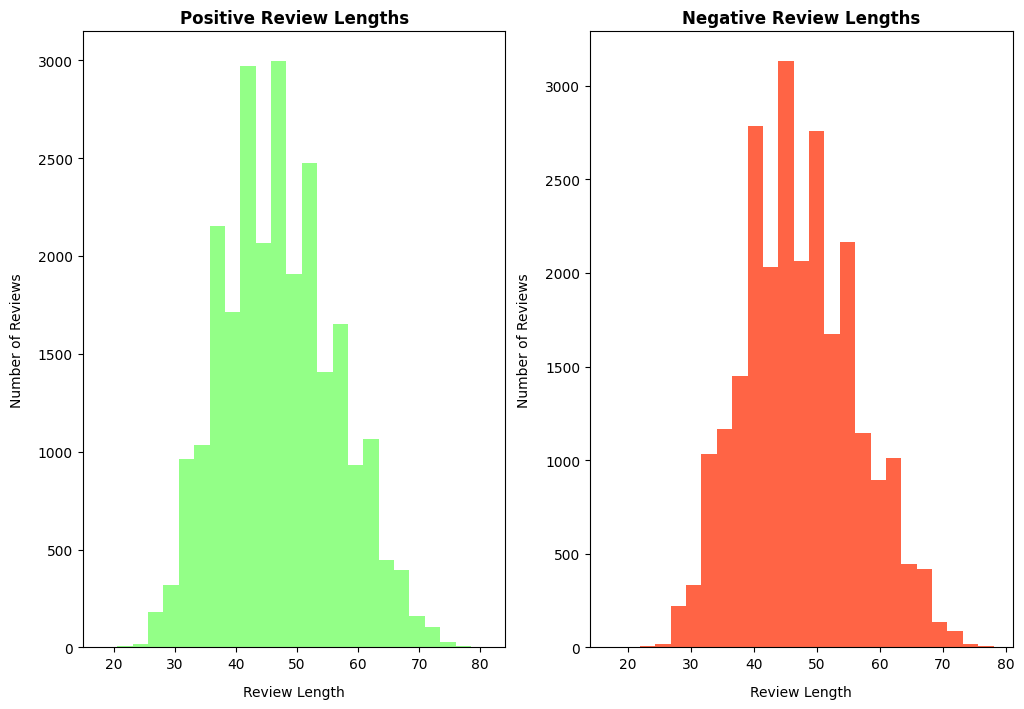

In [9]:
# Create two histograms showing the amount of unique characters per category of sentiment.
# Amount of unique characters per sentiment is used by chaining set() followed by len(), then a conditional where to check the seniment.

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,8))
ax1.hist(reviews_df['review'].apply(set).apply(len).where(reviews_df['sentiment'] == "positive"), bins=25, color="#93ff87")
ax1.set_title("Positive Review Lengths", weight="bold")
ax1.set_xlabel("Review Length", labelpad=10)
ax1.set_ylabel("Number of Reviews", labelpad=10)

ax2.hist(reviews_df['review'].apply(set).apply(len).where(reviews_df['sentiment'] == "negative"), bins=25,  color="#ff6445")
ax2.set_title("Negative Review Lengths", weight="bold")
ax2.set_xlabel("Review Length", labelpad=10)
ax2.set_ylabel("Number of Reviews", labelpad=10)

As shown above, there are no discernable differences between the amount of unique characters used between positive and negative reviews. This highlights that, no matter the sentiment, similar ranges of characters are used (i.e. punctuation, range of vocabulary, emojis, etc).

## Feature Extraction

In this section the features will be extracted, ready to be fed into the machine learning classifier.

This process includes the following steps:

*   Creation of train and test data sets.
*   Word tokenization.
*   Set all text to lowercase.
*   Remove all punctuation.
*   Remove all stop words.
*   Lemmatization.
*   Creation of Ngrams (Unigrams and Bigrams).
*   Term Frequency - Inverse Document Frequency (TF-IDF) vectorization.

In [10]:
reviews_df['review'].head()[0] # Output the first review to demonstrate the format.

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

### Data Normalization

First, create the custom pre-processing function.

As sklearn's TfidfVectorizer() will be used, methods such as tokenization, stop word removal and ngram creation are handled within the call to this vectorizer.

Because of this, the custom pre-processing function will only need to remove punctuation, convert to lowercase and lemmatize the input text.

In [11]:
lemmatizer = WordNetLemmatizer() # Initialise lemmatizer

# Pre-processing function.
#   Parameter 'text' will be a tokenized word.
#   Returns the word after punctuation has been removed and it has been lemmatized.
def pre_processor(text):
  return lemmatizer.lemmatize(text).translate(str.maketrans('','',punctuation)).lower()


Next, pre-process the list of stop words to ensure they remain consistent with the data.

For example, the stop word "you'll" will never match to a word inside the dataset as - after pre-processing - "you'll" will become "youll".

In [12]:
stopwords_file = open("gdrive/MyDrive/Colab Notebooks/stopwords_large.txt", "r")
try:
  content = stopwords_file.read()
  stopwords_list = set(content.split(","))
finally:
  stopwords_file.close()

# Nomalize stopwords to keep consistency with the text it will be matching
stopwords_list = [pre_processor(x) for x in stopwords_list]
print(stopwords_list)

[' vols', ' thats', ' thered', ' world', '', ' mug', ' h', ' kept', ' widely', ' within', ' up', ' downwards', ' av', ' keeps', ' over', ' usefulness', ' usually', ' http', ' hence', ' certainly', ' never', ' thereto', ' ten', ' havent', ' thereupon', ' unfortunately', ' anyone', ' ee', ' pr', ' regards', ' howbeit', ' strongly', ' 6b', ' overall', ' tends', ' vs', ' bu', ' following', ' theyre', ' qv', ' whats', ' uo', ' youre', ' ab', ' getting', ' hu', ' recent', ' believe', ' except', ' weren', ' itll', ' know', ' whys', ' ng', ' hither', ' did', ' cd', ' mn', ' tx', ' awfully', ' rc', ' ia', ' youve', ' ls', ' become', ' ec', ' didn', ' actually', ' etc', ' happens', ' old', ' specify', ' eleven', ' their', ' cmon', ' w', ' x', ' yes', ' out', ' h2', ' wasnt', ' possibly', ' there', ' ae', ' c2', ' isnt', ' whereas', ' each', ' noone', ' research', ' hasnt', ' com', ' too', ' u201d', ' us', ' best', ' pp', ' nos', ' dy', ' fire', ' right', ' volumtype', ' pe', ' thank', ' well', '

### Train/Test Dataset Creation

Create the training and testing data sets with a test size of 20%.

Meaning that 80% of the IMDB reviews dataset will be used to train the machine learning model.

In [13]:

x = reviews_df['review'].values # Get all review values to be used as the X row.
y = reviews_df['sentiment'].values # Get all sentiment values to be used as the Y column.

# Split data into a 80/20 split for training and testing.
(x_train, x_test, y_train, y_test) = train_test_split(x,y,test_size=0.2, random_state=20)
(x_short_train, x_short_test, y_long_train, y_long_test) = train_test_split(x,y,test_size=0.8, random_state=20) # rename

print("Training Set Size: " + str(len(x_train)))
print("Testing Set Size: " + str(len(x_test)))


Training Set Size: 40000
Testing Set Size: 10000


### Tokenization, Stopword Removal, Ngram Creation, Vectorization

Initialise the vectorizer object, setting the following parameters:
*   Use the custom pre-processor defined above.
*   Use NLTK's work tokenizer.
*   Use the stop words list previously initialised and pre-processed.
*   Set all characters to lowercase.

In addition, the following hyperparameters are set:
*   Max document frequency of 0.2 (20%). As a result, any features found in more than 20% of all documents will be removed.
*   Min document frequency of 1. As a result, any features found only in 1 document will be removed.
*   Ngram range of (2,4). This will use Bigrams, 3-grams, and 4-grams to create menaingful features.



In [14]:
vect = TfidfVectorizer(preprocessor=pre_processor, tokenizer=word_tokenize, stop_words=stopwords_list, max_df=0.2, min_df=1, ngram_range=(2,3))

With the vectorizer initialised, fit the vectorizer to the training dataset.

In addition, transform both the training and testing datasets.

In [15]:
x_train_vect = vect.fit_transform(x_train) # Fit and transform the training dataset.
x_test_vect = vect.transform(x_test) # Transform the testing dataset.

x_short_train_vect = vect.fit_transform(x_short_train)
x_short_test_vect = vect.transform(x_short_test)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['0s', '3a', '3b', '3d', '6b', '6o', 'a', 'a1', 'a2', 'a3', 'a4', 'ab', 'able', 'about', 'above', 'abst', 'ac', 'accordance', 'according', 'accordingly', 'across', 'act', 'actually', 'ad', 'added', 'adj', 'ae', 'af', 'affected', 'affecting', 'affects', 'after', 'afterwards', 'ag', 'again', 'against', 'ah', 'ain', 'aint', 'aj', 'al', 'all', 'allow', 'allows', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'amoungst', 'amount', 'an', 'and', 'announce', 'another', 'any', 'anybody', 'anyhow', 'anymore', 'anyone', 'anything', 'anyway', 'anyways', 'anywhere', 'ao', '

After fitting and transforming, view the amount of terms removed by TF-IDF vectorization.

In [16]:
print("Amount of terms removed by TF-IDF: " + str(len(vect.stop_words_)))

Amount of terms removed by TF-IDF: 23


With vectorization complete and the datasets tranformed, the input is ready to be fed into a classification model.

# Classification



## Model Selection

Test the the classifiers MultinomialNB, BernoulliNB, and Logistic Regression to determine the one that performs the best with the given data.

In [17]:
# Initialise all classifiers under comparison.
mnb = MultinomialNB()
bnb = BernoulliNB()
lr = LogisticRegression()
svm = SVC(kernel="linear")

In [18]:
# Fit all classifiers
mnb.fit(x_train_vect, y_train)
bnb.fit(x_train_vect, y_train)
lr.fit(x_train_vect, y_train)
svm.fit(x_short_train_vect, y_long_train)

SVC(kernel='linear')

In [19]:
# Make predictions
mnb_y_pred = mnb.predict(x_test_vect)
bnb_y_pred = bnb.predict(x_test_vect)
lr_y_pred = lr.predict(x_test_vect)
svm_y_pred = svm.predict(x_short_test_vect)

In [20]:
# Output F1 scores
print("Multinomial Naive Bayes F1 Score: " + str(f1_score(y_test, mnb_y_pred, pos_label='positive')))
print("Bernoulli Naive Bayes F1 Score: " + str(f1_score(y_test, bnb_y_pred, pos_label='positive')))
print("Logistic Regression F1 Score: " + str(f1_score(y_test, lr_y_pred, pos_label='positive')))
print("Support Vector Machine F1 Score: " + str(f1_score(y_long_test, svm_y_pred, pos_label='positive')))

Multinomial Naive Bayes F1 Score: 0.8977869274318065
Bernoulli Naive Bayes F1 Score: 0.8909923028916164
Logistic Regression F1 Score: 0.8873295910184443
Support Vector Machine F1 Score: 0.8774190363349131


As seen above, MultinomialNB performs the best when using the F1 score as a model comparison method.

## Model Tuning

Use a pipeline and parameter grid to tune the hyperparameters of the TfidfVectorizer and Multinomical NB; optimizing the model.

In [21]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(preprocessor=pre_processor, tokenizer=word_tokenize, stop_words=stopwords_list)),
    ('mnb', MultinomialNB())
])

param_grid = [{
    'tfidf__max_df': (0.25, 0.3, 0.4, 0.5, 0.75),
    'tfidf__min_df': (1, 3, 5),
    'tfidf__ngram_range': [(1,2), (1,3), (2,3), (2,4)],
    'mnb__alpha': (0.01, 0.1, 1, 10, 100)
}]
scorer = make_scorer(f1_score, pos_label="positive")  # Create custom scorer to enable the setting of pos_label.
random_search = RandomizedSearchCV(pipeline, param_grid, random_state=10, scoring=scorer, n_iter=5, cv=3, n_jobs=-1)

In [22]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning) # Ignore user warnings received from sklearn that clog up the output.
random_search.fit(x_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('tfidf',
                                              TfidfVectorizer(preprocessor=<function pre_processor at 0x7c8ca22af7f0>,
                                                              stop_words=[' '
                                                                          'vols',
                                                                          ' '
                                                                          'thats',
                                                                          ' '
                                                                          'thered',
                                                                          ' '
                                                                          'world',
                                                                          '',
                                                                          ' '
                                                                          'mug',
                                                                          ' h',
                                                                          ' '
                                                                          'kept',
                                                                          ' '
                                                                          'widely',
                                                                          ' '
                                                                          'within',
                                                                          ' up',
                                                                          ' '
                                                                          'downwards',
                                                                          ' av',
                                                                          ' '
                                                                          'keeps',
                                                                          ' '
                                                                          'over',
                                                                          ' '
                                                                          'usefulness',
                                                                          ' '
                                                                          'usually',
                                                                          ' '
                                                                          'http',
                                                                          ' '
                                                                          'hence',
                                                                          ' '
                                                                          'certainly',
                                                                          ' '
                                                                          'never',
                                                                          ' '
                                                                          'thereto'...
                                                                          ' pr',
                                                                          ' '
                                                                          'regards', ...],
                                                              tokenizer=<function word_tokenize at 0x7c8ca4714e50>)),
                                             ('mnb', MultinomialNB())]),
                   n_iter=5, n_jobs=-1,
                   param_distributions=[{'mnb__alpha': (0.01, 0.1, 1, 10, 100),
      

Output the best combination of hyperparameters.

In [23]:
mnb_tuned = random_search.best_estimator_
random_search.best_params_

{'tfidf__ngram_range': (1, 3),
 'tfidf__min_df': 3,
 'tfidf__max_df': 0.25,
 'mnb__alpha': 0.1}

In [24]:
tuned_y_pred = mnb_tuned.predict(x_test) # Make predictions on the test data to be used to calculate metrics.

In [25]:
print("F1 score before tuning: " + str(f1_score(y_test, mnb_y_pred, pos_label='positive')))
print("F1 score after tuning: " + str(f1_score(y_test, tuned_y_pred, pos_label='positive')))

F1 score before tuning: 0.8977869274318065
F1 score after tuning: 0.9021585636473672


As shown above, tuning the model gives a small increase in accuracy.

## Model Evaluation

### Learning Curve

Initialise the Multinomial Naive Bayes object and output the learning curve to visualise the effect of the size of the training set against the model's accuracy in classification.

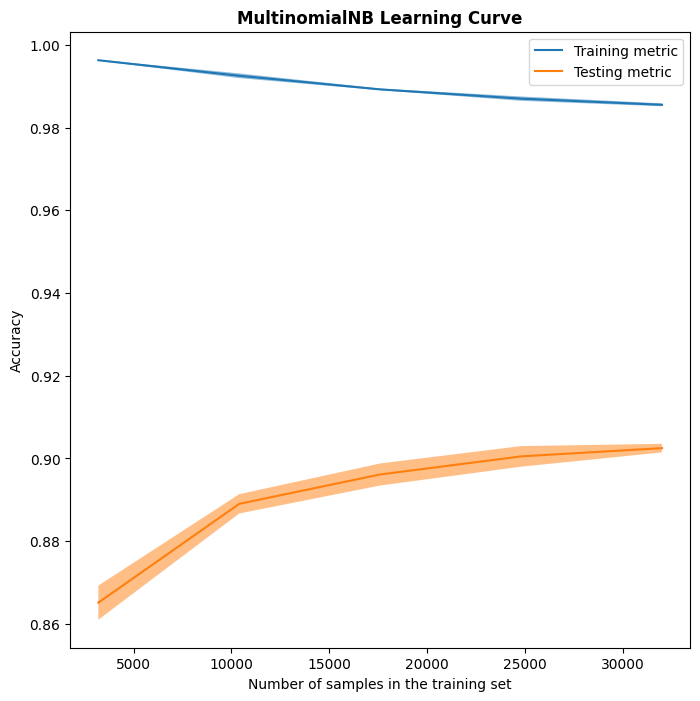

In [26]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
LearningCurveDisplay.from_estimator(mnb_tuned, X=x_train, y=y_train, score_type="both", score_name="Accuracy", n_jobs=-1, ax=ax1)

ax1.set_title("MultinomialNB Learning Curve", weight="bold")

plt.show()

The learning curve indicates that the number of samples in the training set is optimal and has plateaued with an accuracy of ~0.9 using 30000 samples in the training set.

In addition, there is little evidence of over/under-fitting.

### F1 Score

Output the final F1 score.

In [27]:
print("F1 Score: " + str(f1_score(y_test, tuned_y_pred, pos_label='positive'))) # Get F1 score of the test data predictions.

F1 Score: 0.9021585636473672


### Accuracy Score

This measures the percentage of correct predictions made on the testing dataset.

In [28]:
print("Accuracy Score: " + str(accuracy_score(y_test, tuned_y_pred))) # Get accuracy of the test data predictions.

Accuracy Score: 0.903


An accuracy score of 90.8% indicates a strong amount of accuracy when making predictions on the dataset.



In [29]:
print(classification_report(y_test, tuned_y_pred)) # Output the classification report using print() for better formatting.

              precision    recall  f1-score   support

    negative       0.91      0.90      0.90      5071
    positive       0.90      0.91      0.90      4929

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



### Confusion Matrix

Output a confusion matrix to identify the amount of False Positive (Type 1) and False Negative (Type 2) errors.

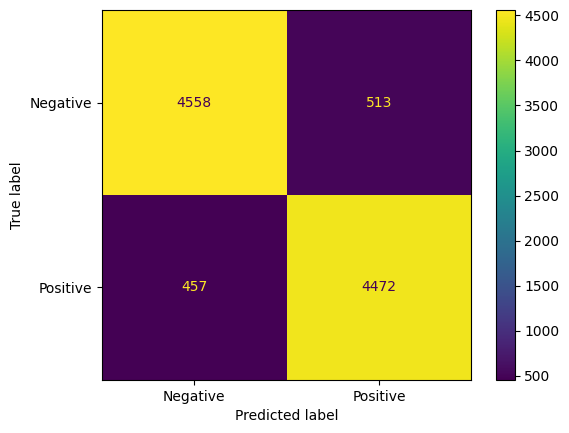

In [33]:
cm = confusion_matrix(y_test, tuned_y_pred, labels=["negative", "positive"]) # Initialise confusion matrix object.
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"]) # Initialise a confusion matrix display.
display.plot() # Output the display.

As shown above, the amount of Type 1 and Type 2 error remain relatively equal, indicating little bias.

This classification problem of identifying sentiments of movie reviews features little difference between the significance of causing a Type 1 or Type 2 error. Therefore, no further work is needed to cause the model to reduce the amount of a particular type of error.

### ROC and Precision-Recall Curves

Output both the ROC and Precision-Recall curves from this model.

The ROC curve indicates the model's sensitivity (True Positive Rate) against a models specificity (1 - False Positive Rate). Generally, the closer an ROC curve is to the top-left of the graph, the better the model's performance.

The Precision-Recall curve indicates a model's precision (where a higher value indicates a low false positive rate) against a model's recall (where a higher value indicates a low false negative rate). Generally, the closer a Precision-Recall curve is to the top-right, the better the models performance (low false positive and negative predictions).

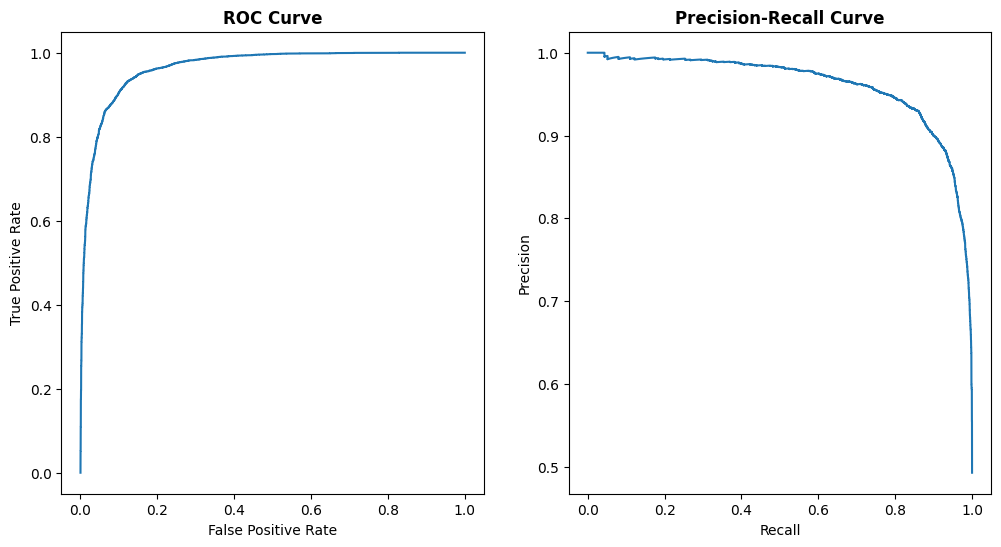

In [34]:
y_proba = mnb_tuned.predict_proba(x_test) # Get both the negative/positive probabilities for each element in the dataset.

prec, recall, _ = precision_recall_curve(y_test, y_proba[:,1], pos_label="positive") # Initialise Precision-Recall curve.
fpr, tpr, threshholds = roc_curve(y_test, y_proba[:,1], pos_label="positive") # Initialise ROC curve.

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6)) # Create subplots to display two graphs.

ax1.set_title("ROC Curve", weight="bold") # Set title for ROC display.
ax2.set_title("Precision-Recall Curve", weight="bold") # Set title for Precision-Recall display.

roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax1) # Initialise ROC Curve display.
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot(ax=ax2) # Initialise Precision-Recall display.
plt.show() # Show the graphs.

In [35]:
print("ROC AUC Score:\t\t\t%.2f" % round((roc_auc_score(y_test, y_proba[:,1])), 2)) # Get and output combined ROC AUC score.
print("Average Precision Score:\t%.2f" % round(average_precision_score(y_test, y_proba[:,1], pos_label="positive"), 2)) # Get and output the average precision recall score.

ROC AUC Score:			0.97
Average Precision Score:	0.96


From visualising the graphs and viewing the ROC Area Under Curve (AUC) and average Precision score, it can be seen that the model performs well and works with both scores equalling 0.97.

# Using the model in other applications

This section will demonstrate how the model can be used in other applications.

First, the model is serialized (using pickle) and then saved to a file.

In [ ]:
import pickle

# Open file to store the data
write_file = open('multinomial_nb_model.pkl', 'wb')

# Serialize the model to file named multinomial_nb_model.pkl in the current working directory.
pickle.dump(mnb_tuned, write_file)

#Close the file.
write_file.close()

For use in other applications, it can be deserialized using pickle.

For example:

In [ ]:
read_file = open('multinomial_nb_model.pkl', 'rb') # Open the file containing the model in read format.
model = pickle.load(read_file) # Perform deserialization.
read_file.close() # Close the file.

With the model loaded, it can then be used for predictions.

Example of making a prediction on a single review:

In [ ]:
def single_pred(review):
  return model.predict([review])[0]

In [ ]:
review = "This is the best movie I have ever seen in my life!"
ans = single_pred(review)
print("The review \"" + review + "\" is " + ans)

Example of making predictions on a batch of reviews:

In [ ]:
def multiple_pred(reviews):
  return [model.predict([x])[0] for x in reviews]

In [ ]:
reviews = [
    "This is the best movie I have ever seen in my life!",
    "This movie is terrible, I haven't quite seen anything so bad in my life"
]

multiple_pred(reviews)